# Librerie 

In [1]:
#Base
import os
import pandas as pd
import numpy as np
import scipy as sp
import time
import sys
import matplotlib as plt
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.metrics import (
    accuracy_score,      # Accuracy = (TP + TN) / (TP + TN + FP + FN) → percentuale predizioni corrette
    precision_score,     # Precision = TP / (TP + FP) → quanti dei positivi predetti sono corretti
    recall_score,        # Recall = TP / (TP + FN) → quanti veri positivi sono stati trovati
    confusion_matrix,    # Matrice con: TP = veri positivi, FP = falsi positivi, FN = falsi negativi, TN = veri negativi
    f1_score             # F1 = 2 * (Precision * Recall) / (Precision + Recall) → misura che considera precision e recall
)

#Path
sys.path.insert(1,'../Data') 
#Importing preprocessing functions
from preprocessing_v3 import preprocessing_diabetes_v3,combination_features





# Funzioni

In [2]:
#modello 
# Descrizione pricipali parametri KNeighborsClassifier() : 

# n_neighbors: num vicini per classificazione.
# weights: come pesare i vicini.
# metric: tipo di distanza usata (es. 'euclidean' o 'manhattan').
# algorithm: metodo usato per trovare i vicini (auto sceglie il migliore 
# in base ai dati passati attraverso fit). Vedere documentazione per varianti

from sklearn import metrics


def knn_grid_search(X_train_in, y_train_in, max_neighbors=5, num_partizioni=5):
    KNN = KNeighborsClassifier() 

    #Grid space

    search_space = {
    'n_neighbors': list(range(1, max_neighbors + 1)),  # ad esempio: [2, 3, 4, 5, k],
    'weights': ['uniform', 'distance'],
    # 'uniform' = tutti i vicini hanno lo stesso peso nel voto
    # 'distance' = i vicini più vicini hanno più peso (peso = 1 / distanza)
    'metric': ['euclidean', 'manhattan']
}


    #Grid search with cross-validation
    grid_search = GridSearchCV(
    KNN,
    param_grid = search_space,
    scoring = { "accuracy": "accuracy",
                "precision": "precision",
                "recall": "recall",
                "f1": "f1" },
    
    refit='f1', # metrica di valutazione
    cv= num_partizioni,   # fold cross-validation 
    )
    
    #-----------------------------------------------------------------------------------------
    #COMMENTO 
    #Durante la Grid Search con cross-validation, per ogni combinazione di iperparametri
    # vengono calcolate e salvate tutte le metriche specificate (accuracy, precision, recall, f1)
    # su ciascuna fold della cross-validation. 
    # Il modello finale restituito è quello che massimizza la metrica indicata con 'refit' (f1),
    # e viene rifittato su tutto il training set con i migliori iperparametri trovati.
    #-----------------------------------------------------------------------------------------
   
    
    #Adattamento del modello ai dati di addestramento
    
    grid_search.fit(X_train_in, y_train_in)
    
    #-----------------------------------------------------------------------------------------
    #COMMENTO 
    # I valori medi delle metriche calcolate durante la cross-validation sono salvati in cv_results_.
     # Tuttavia, cv_results_ contiene i risultati per tutte le combinazioni di iperparametri testate.
     # Per ottenere i valori medi delle metriche relativi al modello migliore 
     # bisogna usare l'indice grid_search.best_index_ così da accedere alla riga corretta.
    #-----------------------------------------------------------------------------------------
 
    # CREIAMO UN DATAFRAME CON LE PERFORMANCE DEL MODELLO MIGLIORE da visualizzare in output
    best_index = grid_search.best_index_

    # 1.Estraggo le medie delle metriche per il modello migliore
    mean_accuracy = grid_search.cv_results_['mean_test_accuracy'][best_index]
    mean_precision = grid_search.cv_results_['mean_test_precision'][best_index]
    mean_recall = grid_search.cv_results_['mean_test_recall'][best_index]
    mean_f1 = grid_search.cv_results_['mean_test_f1'][best_index]

    # 2.Creo un DataFrame con le metriche medie della cross-validation per il modello migliore

    cv_metrics_best_model_df = pd.DataFrame(
        [[mean_accuracy, mean_precision, mean_recall, mean_f1]],
        columns=['Accuracy', 'Precision', 'Recall', 'f1'],
        index=['Performance Train']
    )
    #display(cv_metrics_best_model_df)

    
    KNN_Best= grid_search.best_estimator_    # modello con i migliori parametri, già fit
    Parameter_Best = grid_search.best_params_    # dizionario con i migliori parametri trovati

    
    return KNN_Best, Parameter_Best , cv_metrics_best_model_df


def evaluate_knn(knn_model, X_test, y_test, label='test'):
    start=time.time()
    y_pred = knn_model.predict(X_test)
    end=time.time()
    TempoEsecuzione = end - start
    accuracy = accuracy_score(y_test, y_pred)      
    precision = precision_score(y_test, y_pred)     
    recall = recall_score(y_test, y_pred)           
    f1 = f1_score(y_test, y_pred)                   
    
    # Creazione DataFrame performance 
    metrics_df = pd.DataFrame(
    data=[[accuracy, precision, recall, f1, TempoEsecuzione]],   # Riga di valori calcolati
    columns=['Accuracy', 'Precision', 'Recall', 'f1','Time'],  # Nomi delle colonne
    index=[label]                               # Etichetta della riga, es. 'PCA', 'Classico', ecc.
    )

    conf_mat=confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(conf_mat,
                        index=['Reali sani', 'Reali diabetici'],
                        columns=['Predetti sani', 'Predetti diabetici']

            )
    return metrics_df, cm_df, 




# Importazione dati

In [3]:
train_data= pd.read_csv('../Data/diabetes_train.csv')
test_data= pd.read_csv('../Data/diabetes_test.csv')

# Modello con diversi PREPROCESSING 

### oversample=false augment=false 


,ModelName,Accuracy,Precision,Recall,f1,metric,n_neighbors,weights
0,Normal,0.969229,0.942917,0.938571,0.937319,manhattan,12,distance
1,PCA,0.965839,0.960298,0.904286,0.927443,euclidean,2,uniform
2,No Correlation,0.965809,0.922183,0.951905,0.932943,manhattan,5,distance
3,No Smoking,0.965868,0.925833,0.945238,0.932658,manhattan,4,distance


,ModelName,Accuracy,Precision,Recall,f1,Time
0,Normal,0.952381,0.894737,0.918919,0.906667,0.006073
1,PCA,0.931973,0.864865,0.864865,0.864865,0.016038
2,No Correlation,0.952381,0.894737,0.918919,0.906667,0.005717
3,No Smoking,0.945578,0.853659,0.945946,0.897436,0.004378


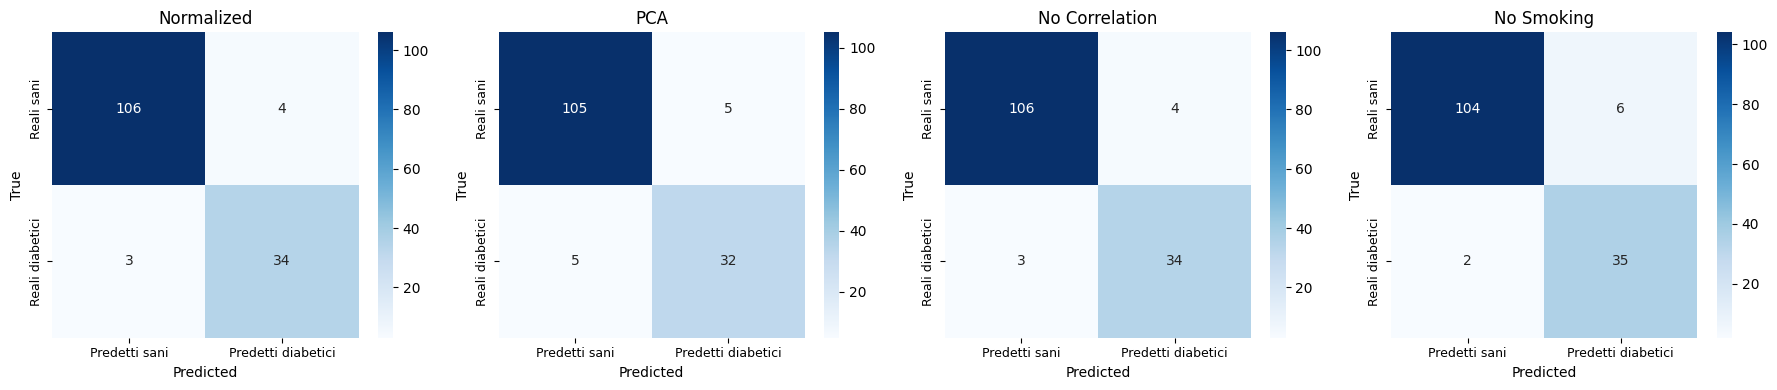

In [4]:
#Normal 
X_train_norm, X_test_norm, y_train_norm, y_test_norm = preprocessing_diabetes_v3(train_data, test_data, augment=False, oversample=False, delete_smoking=False)
knn_best_norm, best_params_norm, performance_train_df_norm = knn_grid_search(X_train_norm, y_train_norm, max_neighbors=30, num_partizioni=10)
parameters_norm = pd.DataFrame([best_params_norm], index=["PARAMETERS BEST KNN"])
metrics_df_norm, conf_mat_norm = evaluate_knn(knn_best_norm, X_test_norm, y_test_norm, label='Performaramce Test')

# PCA
X_train_PCA, X_test_PCA, y_train_PCA, y_test_PCA = preprocessing_diabetes_v3(train_data, test_data, option='PCA', augment=False, oversample=False, delete_smoking=False)
knn_best_PCA, best_params_PCA, performance_train_df_PCA = knn_grid_search(X_train_PCA, y_train_PCA, max_neighbors=30, num_partizioni=10)
parameters_PCA = pd.DataFrame([best_params_PCA], index=["PARAMETERS BEST KNN"])
metrics_df_PCA, conf_mat_PCA = evaluate_knn(knn_best_PCA, X_test_PCA, y_test_PCA, label='Performance Test')

#No Correlation
X_train_noCorr, X_test_noCorr, y_train_noCorr, y_test_noCorr = preprocessing_diabetes_v3(train_data, test_data, option='Delete', augment=False, oversample=False, delete_smoking=False)
knn_best_noCorr, best_params_noCorr, performance_train_df_noCorr = knn_grid_search(X_train_noCorr, y_train_noCorr, max_neighbors=30, num_partizioni=10)
parameters_noCorr = pd.DataFrame([best_params_noCorr], index=["PARAMETERS BEST KNN"])
metrics_df_noCorr, conf_mat_noCorr = evaluate_knn(knn_best_noCorr, X_test_noCorr, y_test_noCorr, label='Performance Test')

#No Smoking
X_train_NoSmok, X_test_NoSmok, y_train_NoSmok, y_test_NoSmok = preprocessing_diabetes_v3(train_data, test_data, augment=False, oversample=False, delete_smoking=True)
knn_best_NoSmok, best_params_NoSmok, performance_train_df_NoSmok = knn_grid_search(X_train_NoSmok, y_train_NoSmok, max_neighbors=30, num_partizioni=10)
parameters_NoSmok = pd.DataFrame([best_params_NoSmok], index=["PARAMETERS BEST KNN"])
metrics_df_NoSmok, conf_mat_NoSmok = evaluate_knn(knn_best_NoSmok, X_test_NoSmok, y_test_NoSmok, label='Performance Test')


#_________________________________________________________________________________________________________________________
# OUTPUT

#PERFORMANCE TRAINING

df_norm_test = performance_train_df_norm.reset_index(drop=True).copy()
df_norm_test['ModelName'] = 'Normal'
df_PCA_test = performance_train_df_PCA.reset_index(drop=True).copy()
df_PCA_test['ModelName'] = 'PCA'
df_noCorr_test = performance_train_df_noCorr.reset_index(drop=True).copy()
df_noCorr_test['ModelName'] = 'No Correlation'
df_NoSmok_test = performance_train_df_NoSmok.reset_index(drop=True).copy()
df_NoSmok_test['ModelName'] = 'No Smoking'

# Concatenazione
performance_train_all = pd.concat([df_norm_test, df_PCA_test, df_noCorr_test, df_NoSmok_test], ignore_index=True)
performance_train_all = performance_train_all[['ModelName', 'Accuracy', 'Precision', 'Recall', 'f1']]
pperformance_train_all = performance_train_all.set_index('ModelName')

#PARAMETRI MODELLO

parameters_norm_cp = parameters_norm.reset_index(drop=True).copy()
parameters_norm_cp['ModelName'] = 'Normal'
parameters_PCA_cp = parameters_PCA.reset_index(drop=True).copy()
parameters_PCA_cp['ModelName'] = 'PCA'
parameters_noCorr_cp = parameters_noCorr.reset_index(drop=True).copy()
parameters_noCorr_cp['ModelName'] = 'No Correlation'
parameters_NoSmok_cp = parameters_NoSmok.reset_index(drop=True).copy()
parameters_NoSmok_cp['ModelName'] = 'No Smoking'

# Concatenazione 
parameters_all = pd.concat([parameters_norm_cp, parameters_PCA_cp, parameters_noCorr_cp, parameters_NoSmok_cp], ignore_index=True)
parameters_all = parameters_all[['ModelName', 'metric', 'n_neighbors', 'weights']]

# Unisco performance e parametri usando 'ModelName' come chiave
df_combined = performance_train_all.merge(parameters_all, on='ModelName')

display(df_combined)

#----------------------------------------------------------------------------------------------------
#PERFORMANCE TEST
df_norm_test = metrics_df_norm.reset_index(drop=True).copy()
df_norm_test['ModelName'] = 'Normal'
df_PCA_test = metrics_df_PCA.reset_index(drop=True).copy()
df_PCA_test['ModelName'] = 'PCA'
df_noCorr_test = metrics_df_noCorr.reset_index(drop=True).copy()
df_noCorr_test['ModelName'] = 'No Correlation'
df_NoSmok_test = metrics_df_NoSmok.reset_index(drop=True).copy()
df_NoSmok_test['ModelName'] = 'No Smoking'

#Concateniamo
performance_test_all = pd.concat([df_norm_test, df_PCA_test, df_noCorr_test, df_NoSmok_test], ignore_index=True)
performance_test_all = performance_test_all[['ModelName', 'Accuracy', 'Precision', 'Recall', 'f1','Time']]

display(performance_test_all)

#----------------------------------------------------------------------------------------------------

# MATRICI DI CONFUSIONE
fig, axes = plt.subplots(1, 4, figsize=(18, 4))# (righe, colonne)
sns.heatmap(conf_mat_norm, annot=True, fmt='d', cmap='Blues', ax=axes[0], annot_kws={"size": 10})
axes[0].set_title('Normalized', fontsize=12)
axes[0].set_xlabel('Predicted', fontsize=10)
axes[0].set_ylabel('True', fontsize=10)
axes[0].tick_params(axis='both', labelsize=9)

sns.heatmap(conf_mat_PCA, annot=True, fmt='d', cmap='Blues', ax=axes[1], annot_kws={"size": 10})
axes[1].set_title('PCA', fontsize=12)
axes[1].set_xlabel('Predicted', fontsize=10)
axes[1].set_ylabel('True', fontsize=10)
axes[1].tick_params(axis='both', labelsize=9)

sns.heatmap(conf_mat_noCorr, annot=True, fmt='d', cmap='Blues', ax=axes[2], annot_kws={"size": 10})
axes[2].set_title('No Correlation', fontsize=12)
axes[2].set_xlabel('Predicted', fontsize=10)
axes[2].set_ylabel('True', fontsize=10)
axes[2].tick_params(axis='both', labelsize=9)

sns.heatmap(conf_mat_NoSmok, annot=True, fmt='d', cmap='Blues', ax=axes[3], annot_kws={"size": 10})
axes[3].set_title('No Smoking', fontsize=12)
axes[3].set_xlabel('Predicted', fontsize=10)
axes[3].set_ylabel('True', fontsize=10)
axes[3].tick_params(axis='both', labelsize=9)

plt.tight_layout()
plt.show()



### oversample=True augment=True

,Accuracy,Precision,Recall,f1,metric,n_neighbors,weights
ModelName,,,,,,,
Normal,0.974948,0.969823,0.981712,0.975125,manhattan,2,uniform
PCA,0.976136,0.969060,0.984091,0.976374,euclidean,2,uniform
No Correlation,0.976097,0.967413,0.986311,0.976522,manhattan,2,uniform
No Smoking,0.980669,0.971858,0.990909,0.981069,manhattan,2,uniform


,ModelName,Accuracy,Precision,Recall,f1,Time
0,Normal,0.952381,0.875000,0.945946,0.909091,0.025256
1,PCA,0.959184,0.897436,0.945946,0.921053,0.021175
2,No Correlation,0.945578,0.853659,0.945946,0.897436,0.031104
3,No Smoking,0.972789,0.923077,0.972973,0.947368,0.023968


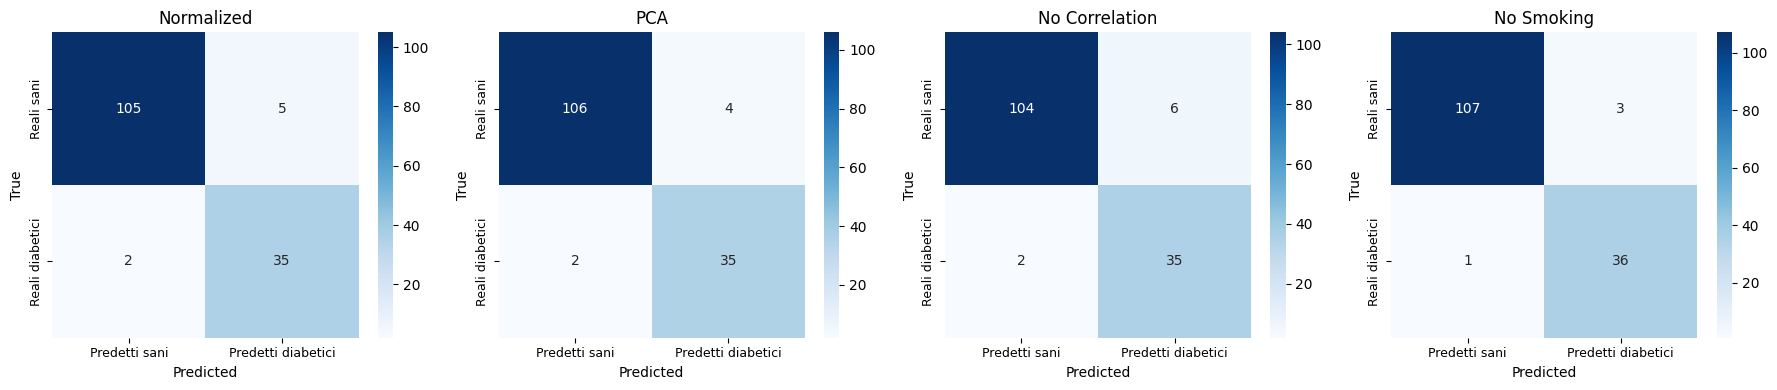

In [5]:
#Normal
X_train_norm2, X_test_norm2, y_train_norm2, y_test_norm2 = preprocessing_diabetes_v3(train_data, test_data, augment=True, oversample=True, delete_smoking=False)
knn_best_norm2, best_params_norm2, performance_train_df_norm2 = knn_grid_search(X_train_norm2, y_train_norm2, max_neighbors=30, num_partizioni=10)
parameters_norm2 = pd.DataFrame([best_params_norm2], index=["PARAMETERS BEST KNN"])
metrics_df_norm2, conf_mat_norm2 = evaluate_knn(knn_best_norm2, X_test_norm2, y_test_norm2, label='Performaramce Test')

# PCA
X_train_PCA2, X_test_PCA2, y_train_PCA2, y_test_PCA2 = preprocessing_diabetes_v3(train_data, test_data, option='PCA',augment=True, oversample=True, delete_smoking=False)
knn_best_PCA2, best_params_PCA2, performance_train_df_PCA2 = knn_grid_search(X_train_PCA2, y_train_PCA2, max_neighbors=30, num_partizioni=10)
parameters_PCA2 = pd.DataFrame([best_params_PCA2], index=["PARAMETERS BEST KNN"])
metrics_df_PCA2, conf_mat_PCA2 = evaluate_knn(knn_best_PCA2, X_test_PCA2, y_test_PCA2, label='Performance Test')

#No Correlation
X_train_noCorr2, X_test_noCorr2, y_train_noCorr2, y_test_noCorr2 = preprocessing_diabetes_v3(train_data, test_data, option='Delete',augment=True, oversample=True, delete_smoking=False)
knn_best_noCorr2, best_params_noCorr2, performance_train_df_noCorr2 = knn_grid_search(X_train_noCorr2, y_train_noCorr2, max_neighbors=30, num_partizioni=10)
parameters_noCorr2 = pd.DataFrame([best_params_noCorr2], index=["PARAMETERS BEST KNN"])
metrics_df_noCorr2, conf_mat_noCorr2 = evaluate_knn(knn_best_noCorr2, X_test_noCorr2, y_test_noCorr2, label='Performance Test')

#No Smoking
X_train_NoSmok2, X_test_NoSmok2, y_train_NoSmok2, y_test_NoSmok2 = preprocessing_diabetes_v3(train_data, test_data, augment=True, oversample=True, delete_smoking=True)
knn_best_NoSmok2, best_params_NoSmok2, performance_train_df_NoSmok2 = knn_grid_search(X_train_NoSmok2, y_train_NoSmok2, max_neighbors=30, num_partizioni=10)
parameters_NoSmok2 = pd.DataFrame([best_params_NoSmok2], index=["PARAMETERS BEST KNN"])
metrics_df_NoSmok2, conf_mat_NoSmok2 = evaluate_knn(knn_best_NoSmok2, X_test_NoSmok2, y_test_NoSmok2, label='Performance Test')

#_________________________________________________________________________________________________________________________
# OUTPUT

#PERFORMANCE TRAINING
df_norm_test2 = performance_train_df_norm2.reset_index(drop=True).copy()
df_norm_test2['ModelName'] = 'Normal'
df_PCA_test2 = performance_train_df_PCA2.reset_index(drop=True).copy()
df_PCA_test2['ModelName'] = 'PCA'
df_noCorr_test2 = performance_train_df_noCorr2.reset_index(drop=True).copy()
df_noCorr_test2['ModelName'] = 'No Correlation'
df_NoSmok_test2 = performance_train_df_NoSmok2.reset_index(drop=True).copy()
df_NoSmok_test2['ModelName'] = 'No Smoking'

#Conatenazione
performance_train_all2 = pd.concat([df_norm_test2, df_PCA_test2, df_noCorr_test2, df_NoSmok_test2], ignore_index=True)
performance_train_all2 = performance_train_all2[['ModelName', 'Accuracy', 'Precision', 'Recall', 'f1']]
performance_train_all2 = performance_train_all2.set_index('ModelName')

#PARAMETRI MODELLO
parameters_norm_cp2 = parameters_norm2.reset_index(drop=True).copy()
parameters_norm_cp2['ModelName'] = 'Normal'
parameters_PCA_cp2 = parameters_PCA2.reset_index(drop=True).copy()
parameters_PCA_cp2['ModelName'] = 'PCA'
parameters_noCorr_cp2 = parameters_noCorr2.reset_index(drop=True).copy()
parameters_noCorr_cp2['ModelName'] = 'No Correlation'
parameters_NoSmok_cp2 = parameters_NoSmok2.reset_index(drop=True).copy()
parameters_NoSmok_cp2['ModelName'] = 'No Smoking'

# Concatenazione
parameters_all2 = pd.concat([parameters_norm_cp2, parameters_PCA_cp2, parameters_noCorr_cp2, parameters_NoSmok_cp2], ignore_index=True)
parameters_all2 = parameters_all2[['ModelName', 'metric', 'n_neighbors', 'weights']]
parameters_all2 = parameters_all2.set_index('ModelName')

#Unisco performance e parametri usando 'ModelName' come chiave
df_combined2 = performance_train_all2.merge(parameters_all2, on='ModelName')


display(df_combined2)

#----------------------------------------------------------------------------------------------------

# PERFORMANCE TEST
df_norm_test2 = metrics_df_norm2.reset_index(drop=True).copy()
df_norm_test2['ModelName'] = 'Normal'
df_PCA_test2 = metrics_df_PCA2.reset_index(drop=True).copy()
df_PCA_test2['ModelName'] = 'PCA'
df_noCorr_test2 = metrics_df_noCorr2.reset_index(drop=True).copy()
df_noCorr_test2['ModelName'] = 'No Correlation'
df_NoSmok_test2 = metrics_df_NoSmok2.reset_index(drop=True).copy()
df_NoSmok_test2['ModelName'] = 'No Smoking'

#Concateniamo
performance_test_all2 = pd.concat([df_norm_test2, df_PCA_test2, df_noCorr_test2, df_NoSmok_test2], ignore_index=True)
performance_test_all2 = performance_test_all2[['ModelName', 'Accuracy', 'Precision', 'Recall', 'f1','Time']]

display(performance_test_all2)

# MATRICI DI CONFUSIONE
fig2, axes2 = plt.subplots(1, 4, figsize=(18, 4))# (righe, colonne)
sns.heatmap(conf_mat_norm2, annot=True, fmt='d', cmap='Blues', ax=axes2[0], annot_kws={"size": 10})
axes2[0].set_title('Normalized', fontsize=12)
axes2[0].set_xlabel('Predicted', fontsize=10)
axes2[0].set_ylabel('True', fontsize=10)
axes2[0].tick_params(axis='both', labelsize=9)

sns.heatmap(conf_mat_PCA2, annot=True, fmt='d', cmap='Blues', ax=axes2[1], annot_kws={"size": 10})
axes2[1].set_title('PCA', fontsize=12)
axes2[1].set_xlabel('Predicted', fontsize=10)
axes2[1].set_ylabel('True', fontsize=10)
axes2[1].tick_params(axis='both', labelsize=9)

sns.heatmap(conf_mat_noCorr2, annot=True, fmt='d', cmap='Blues', ax=axes2[2], annot_kws={"size": 10})
axes2[2].set_title('No Correlation', fontsize=12)
axes2[2].set_xlabel('Predicted', fontsize=10)
axes2[2].set_ylabel('True', fontsize=10)
axes2[2].tick_params(axis='both', labelsize=9)

sns.heatmap(conf_mat_NoSmok2, annot=True, fmt='d', cmap='Blues', ax=axes2[3], annot_kws={"size": 10})
axes2[3].set_title('No Smoking', fontsize=12)
axes2[3].set_xlabel('Predicted', fontsize=10)
axes2[3].set_ylabel('True', fontsize=10)
axes2[3].tick_params(axis='both', labelsize=9)

plt.tight_layout()
plt.show()


 

### oversample=True augment=False 

,Accuracy,Precision,Recall,f1,metric,n_neighbors,weights
ModelName,,,,,,,
Normal,0.980656,0.967238,0.995455,0.981047,manhattan,2,uniform
PCA,0.969292,0.952168,0.988636,0.969987,euclidean,1,uniform
No Correlation,0.976110,0.958914,0.995455,0.976725,manhattan,2,uniform
No Smoking,0.974948,0.963549,0.988636,0.975613,manhattan,2,uniform


,ModelName,Accuracy,Precision,Recall,f1,Time
0,Normal,0.959184,0.878049,0.972973,0.923077,0.020138
1,PCA,0.945578,0.837209,0.972973,0.900000,0.012133
2,No Correlation,0.952381,0.875000,0.945946,0.909091,0.014049
3,No Smoking,0.965986,0.921053,0.945946,0.933333,0.013551


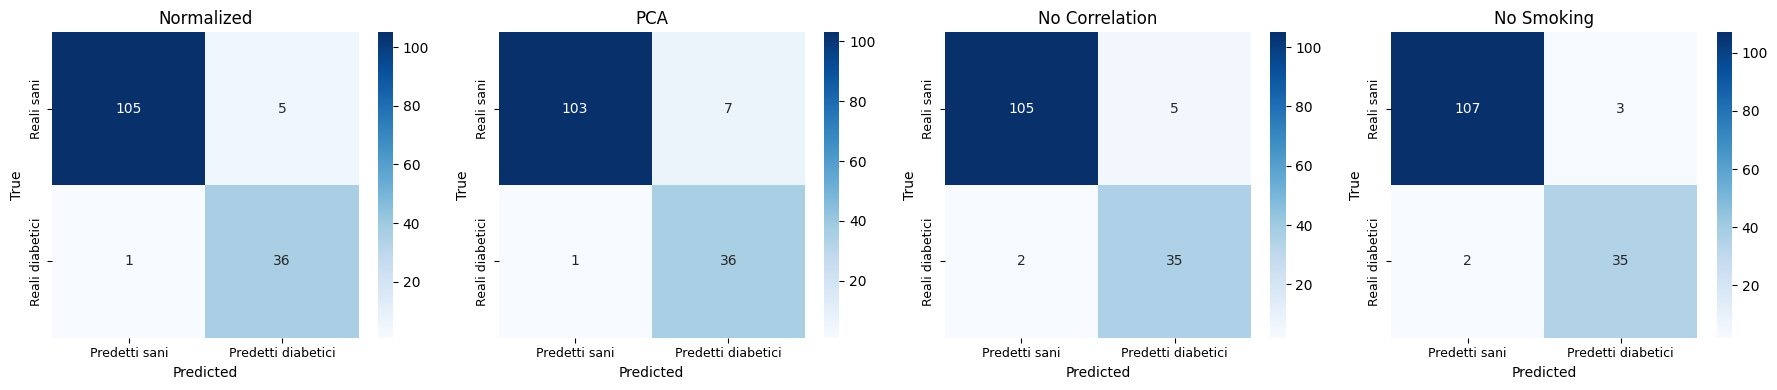

In [6]:
#Normal
X_train_norm3, X_test_norm3, y_train_norm3, y_test_norm3 = preprocessing_diabetes_v3(train_data, test_data, augment=False, oversample=True, delete_smoking=False) 
knn_best_norm3, best_params_norm3, performance_train_df_norm3 = knn_grid_search(X_train_norm3, y_train_norm3, max_neighbors=30, num_partizioni=10)
parameters_norm3 = pd.DataFrame([best_params_norm3], index=["PARAMETERS BEST KNN"])
metrics_df_norm3, conf_mat_norm3 = evaluate_knn(knn_best_norm3, X_test_norm3, y_test_norm3, label='Performaramce Test')

# PCA
X_train_PCA3, X_test_PCA3, y_train_PCA3, y_test_PCA3 = preprocessing_diabetes_v3(train_data, test_data, option='PCA',augment=False, oversample=True, delete_smoking=False)
knn_best_PCA3, best_params_PCA3, performance_train_df_PCA3 = knn_grid_search(X_train_PCA3, y_train_PCA3, max_neighbors=30, num_partizioni=10)
parameters_PCA3 = pd.DataFrame([best_params_PCA3], index=["PARAMETERS BEST KNN"])
metrics_df_PCA3, conf_mat_PCA3 = evaluate_knn(knn_best_PCA3, X_test_PCA3, y_test_PCA3, label='Performance Test')

#No Correlation
X_train_noCorr3, X_test_noCorr3, y_train_noCorr3, y_test_noCorr3 = preprocessing_diabetes_v3(train_data, test_data, option='Delete',augment=False, oversample=True, delete_smoking=False)
knn_best_noCorr3, best_params_noCorr3, performance_train_df_noCorr3 = knn_grid_search(X_train_noCorr3, y_train_noCorr3, max_neighbors=30, num_partizioni=10)
parameters_noCorr3 = pd.DataFrame([best_params_noCorr3], index=["PARAMETERS BEST KNN"])
metrics_df_noCorr3, conf_mat_noCorr3 = evaluate_knn(knn_best_noCorr3, X_test_noCorr3, y_test_noCorr3, label='Performance Test')

#No Smoking
X_train_NoSmok3, X_test_NoSmok3, y_train_NoSmok3, y_test_NoSmok3= preprocessing_diabetes_v3(train_data, test_data, augment=False, oversample=True, delete_smoking=True)
knn_best_NoSmok3, best_params_NoSmok3, performance_train_df_NoSmok3 = knn_grid_search(X_train_NoSmok3, y_train_NoSmok3, max_neighbors=30, num_partizioni=10)
parameters_NoSmok3 = pd.DataFrame([best_params_NoSmok3], index=["PARAMETERS BEST KNN"])
metrics_df_NoSmok3, conf_mat_NoSmok3 = evaluate_knn(knn_best_NoSmok3, X_test_NoSmok3, y_test_NoSmok3, label='PerformPerformance Test')

#_________________________________________________________________________________________________________________________
# OUTPUT


#PERFORMANCE TRAINING
df_norm_test3 = performance_train_df_norm3.reset_index(drop=True).copy()
df_norm_test3['ModelName'] = 'Normal'
df_PCA_test3 = performance_train_df_PCA3.reset_index(drop=True).copy()
df_PCA_test3['ModelName'] = 'PCA'
df_noCorr_test3 = performance_train_df_noCorr3.reset_index(drop=True).copy()
df_noCorr_test3['ModelName'] = 'No Correlation'
df_NoSmok_test3 = performance_train_df_NoSmok3.reset_index(drop=True).copy()
df_NoSmok_test3['ModelName'] = 'No Smoking'
 
#Concateniamo
performance_train_all3 = pd.concat([df_norm_test3, df_PCA_test3, df_noCorr_test3, df_NoSmok_test3], ignore_index=True)
performance_train_all3 = performance_train_all3[['ModelName', 'Accuracy', 'Precision', 'Recall', 'f1']]
performance_train_all3 = performance_train_all3.set_index('ModelName')


#PARAMETRI MODELLO
parameters_norm_cp3 = parameters_norm3.reset_index(drop=True).copy()
parameters_norm_cp3['ModelName'] = 'Normal'
parameters_PCA_cp3 = parameters_PCA3.reset_index(drop=True).copy()
parameters_PCA_cp3['ModelName'] = 'PCA'
parameters_noCorr_cp3 = parameters_noCorr3.reset_index(drop=True).copy()
parameters_noCorr_cp3['ModelName'] = 'No Correlation'
parameters_NoSmok_cp3 = parameters_NoSmok3.reset_index(drop=True).copy()
parameters_NoSmok_cp3['ModelName'] = 'No Smoking'

#Concatenazione
parameters_all3 = pd.concat([parameters_norm_cp3, parameters_PCA_cp3, parameters_noCorr_cp3, parameters_NoSmok_cp3], ignore_index=True)
parameters_all3 = parameters_all3[['ModelName', 'metric', 'n_neighbors', 'weights']]
parameters_all3 = parameters_all3.set_index('ModelName')


# Unisco performance e parametri usando 'ModelName' come chiave
df_combined3 = performance_train_all3.merge(parameters_all3, on='ModelName')

display(df_combined3)

#----------------------------------------------------------------------------------------------------

# PERFORMANCE TEST
df_norm_test3 = metrics_df_norm3.reset_index(drop=True).copy()
df_norm_test3['ModelName'] = 'Normal'
df_PCA_test3 = metrics_df_PCA3.reset_index(drop=True).copy()
df_PCA_test3['ModelName'] = 'PCA'
df_noCorr_test3 = metrics_df_noCorr3.reset_index(drop=True).copy()
df_noCorr_test3['ModelName'] = 'No Correlation'
df_NoSmok_test3 = metrics_df_NoSmok3.reset_index(drop=True).copy()
df_NoSmok_test3['ModelName'] = 'No Smoking'

#Concateniamo
performance_test_all3 = pd.concat([df_norm_test3, df_PCA_test3, df_noCorr_test3, df_NoSmok_test3], ignore_index=True)
performance_test_all3 = performance_test_all3[['ModelName', 'Accuracy', 'Precision', 'Recall', 'f1','Time']]


display(performance_test_all3)

# MATRICI DI CONFUSIONE
fig3, axes3 = plt.subplots(1, 4, figsize=(18, 4))# (righe, colonne)

sns.heatmap(conf_mat_norm3, annot=True, fmt='d', cmap='Blues', ax=axes3[0], annot_kws={"size": 10})
axes3[0].set_title('Normalized', fontsize=12)
axes3[0].set_xlabel('Predicted', fontsize=10)
axes3[0].set_ylabel('True', fontsize=10)
axes3[0].tick_params(axis='both', labelsize=9)

sns.heatmap(conf_mat_PCA3, annot=True, fmt='d', cmap='Blues', ax=axes3[1], annot_kws={"size": 10})
axes3[1].set_title('PCA', fontsize=12)
axes3[1].set_xlabel('Predicted', fontsize=10)
axes3[1].set_ylabel('True', fontsize=10)
axes3[1].tick_params(axis='both', labelsize=9)

sns.heatmap(conf_mat_noCorr3, annot=True, fmt='d', cmap='Blues', ax=axes3[2], annot_kws={"size": 10})
axes3[2].set_title('No Correlation', fontsize=12)
axes3[2].set_xlabel('Predicted', fontsize=10)
axes3[2].set_ylabel('True', fontsize=10)
axes3[2].tick_params(axis='both', labelsize=9)

sns.heatmap(conf_mat_NoSmok3, annot=True, fmt='d', cmap='Blues', ax=axes3[3], annot_kws={"size": 10})
axes3[3].set_title('No Smoking', fontsize=12)
axes3[3].set_xlabel('Predicted', fontsize=10)
axes3[3].set_ylabel('True', fontsize=10)
axes3[3].tick_params(axis='both', labelsize=9)

plt.tight_layout()
plt.show()
